In [1]:
%load_ext tensorboard

In [2]:
import os
import datetime

from collections import defaultdict

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.integrate import solve_ivp
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from assets.ml.DeepONetwork import TrunkNN
from assets.ml.DeepONetwork import BranchNN
from assets.ml.DeepONetwork import DeepONET
from assets.ml.DeepONetwork import DeepOPINN

2023-12-22 00:08:58.477688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
log_dir = os.path.join(".", "assets", "logs", "fits", f"DeepONET_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch= '10, 110')

2023-12-22 00:09:22.626017: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-22 00:09:22.626039: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-12-22 00:09:22.626160: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [4]:
modelPath = os.path.join(".", "assets", "ml", "DeepONET", "deepONET.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', save_best_only=True, save_weights_only=True)

In [5]:
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.9, patience=50, min_lr=1e-9)
_callbacks = [tensorboard_callback, model_checkpoint_callback, learning_rate_callback]
callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=False)

In [6]:
def createSamples(lengthScale, k, domain):
    kernel = RBF(length_scale=lengthScale)
    GP = GaussianProcessRegressor(kernel=kernel)
    u_sample = np.zeros((k, 100))
    for i in range(k):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = GP.sample_y(domain.reshape(-1, 1), random_state=n).flatten()

    return u_sample

In [7]:
domain = np.linspace(0, 1, 100)
U = createSamples(lengthScale=0.2, k=1000, domain=domain)
print(U.shape)

(1000, 100)


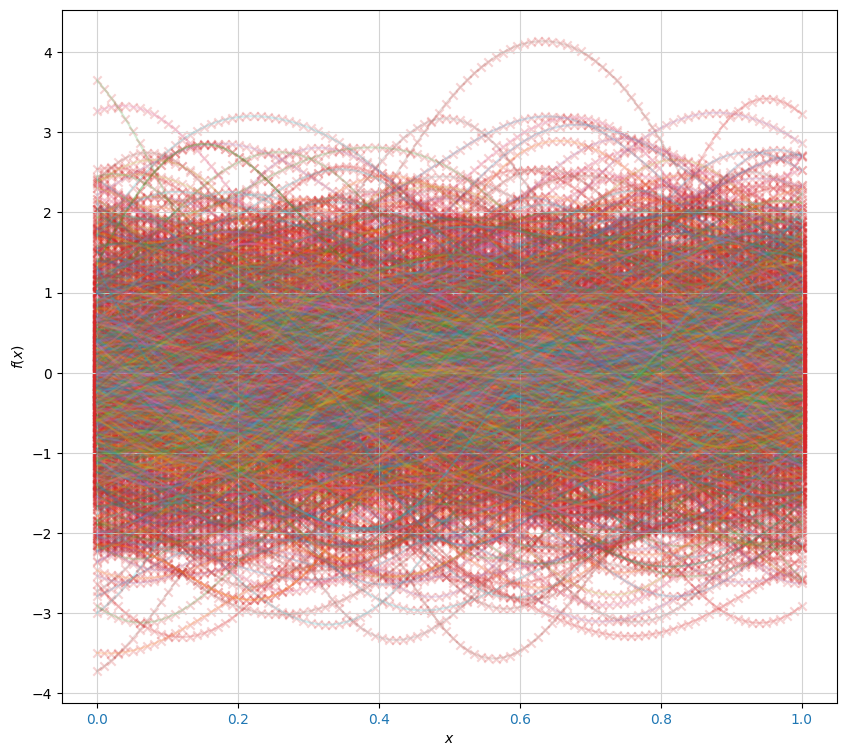

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

for u in U:
    ax.plot(domain, u, alpha = 0.2)
    ax.scatter(domain, u, marker = "x", color = "tab:red", alpha=0.2)

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.grid(True, color='lightgrey')

plt.show()

In [10]:
def solutions(u, t):
    sols = []
    for i in tqdm(range(u.shape[0]), desc="Generating Solutions", ncols=90):
        sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), u[i, :]), t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
        sols.append(sol.y[0].reshape(-1, 1))

    return np.array(sols)

In [11]:
Y = solutions(u=U, t=domain.reshape(-1, 1))
print(Y.shape)

Generating Solutions:   0%|                                      | 0/1000 [00:00<?, ?it/s]

Generating Solutions: 100%|██████████████████████████| 1000/1000 [00:01<00:00, 742.78it/s]

(1000, 100, 1)


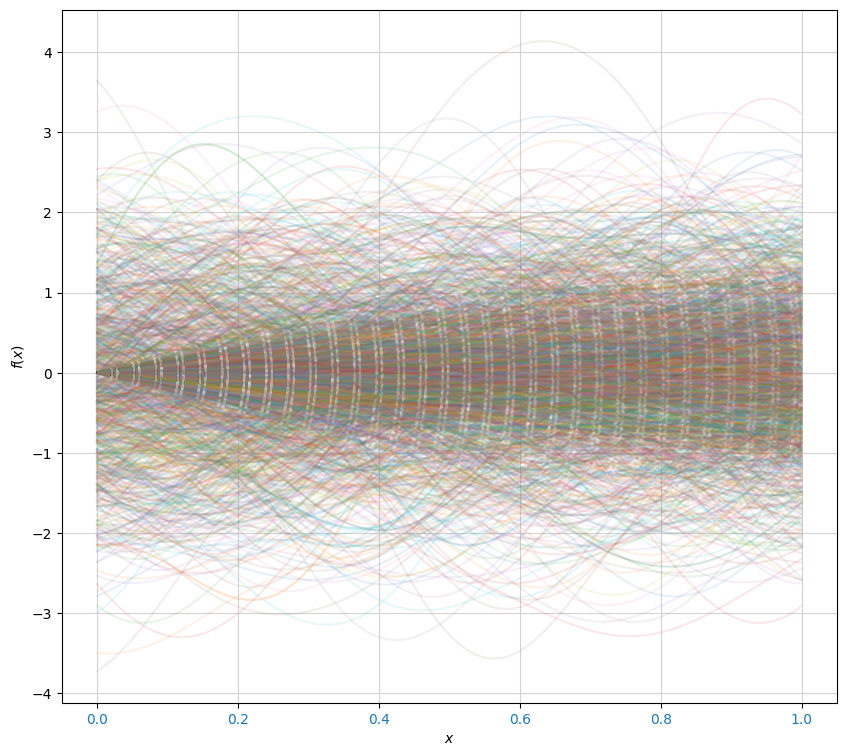

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

for u in U:
    ax.plot(domain, u, alpha=0.1)

for y in Y:
    ax.plot(domain, y, linestyle = "-.", alpha = 0.1)

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.grid(True, color='lightgrey')

plt.show()

In [13]:
branchHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"branchNETDense_layer{i+1}") for i in range(5)]
trunkHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"trunkNETDense_layer{i+1}") for i in range(5)]


branchNET = BranchNN(hiddenLayers=branchHiddenLayers, input_shape=(100,))
trunkNET = TrunkNN(hiddenLayers=trunkHiddenLayers, input_shape=(1,))
deepONET = DeepONET(branchNN=branchNET, trunkNN=trunkNET)

In [14]:
domain = np.linspace(0, 1, 100)

In [15]:
n = 1000

U = createSamples(lengthScale=0.2, k=n, domain=domain)

print(U.shape)
branch_input = []
for u in U:
    for t in domain:
        branch_input.append(u)
branch_input = np.array(branch_input)
print(branch_input.shape)

trunk_input = np.array([domain for i in range(n)]).reshape(-1, 1)
print(trunk_input.shape)

y = solutions(u=U, t=domain.reshape(-1, 1)).reshape(-1, 1)
print(y.shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
deepONET.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.losses.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])

(1000, 100)
(100000, 100)
(100000, 1)


Generating Solutions: 100%|██████████████████████████| 1000/1000 [00:01<00:00, 841.48it/s]

(100000, 1)


In [16]:
deepONET.build(input_shape=[(None, 100), (None, 1)])

In [17]:
deepONET.summary()

Model: "deep_onet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 branch_nn (BranchNN)        multiple                  4120      
                                                                 
 trunk_nn (TrunkNN)          multiple                  2140      
                                                                 
 bias_layer (BiasLayer)      multiple                  1         
                                                                 
Total params: 6261 (24.46 KB)
Trainable params: 6261 (24.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
deepONET.fit(x=[branch_input, trunk_input], y=y, epochs=5000, verbose=False, batch_size=100, validation_split=0.25, callbacks=_callbacks)

2023-12-22 00:10:38.676904: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-22 00:10:38.676923: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-12-22 00:10:38.935057: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-12-22 00:10:40.005032: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-12-22 00:10:40.007139: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: ./assets/logs/fits/DeepONET_20231222-000922/plugins/profile/2023_12_22_00_10_40/bmbp.modem.xplane.pb


In [19]:
deepONET.load_weights(filepath=modelPath)

testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.2, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

Generating Solutions: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 80.42it/s]

(100,)
(1, 100)
(100, 1)


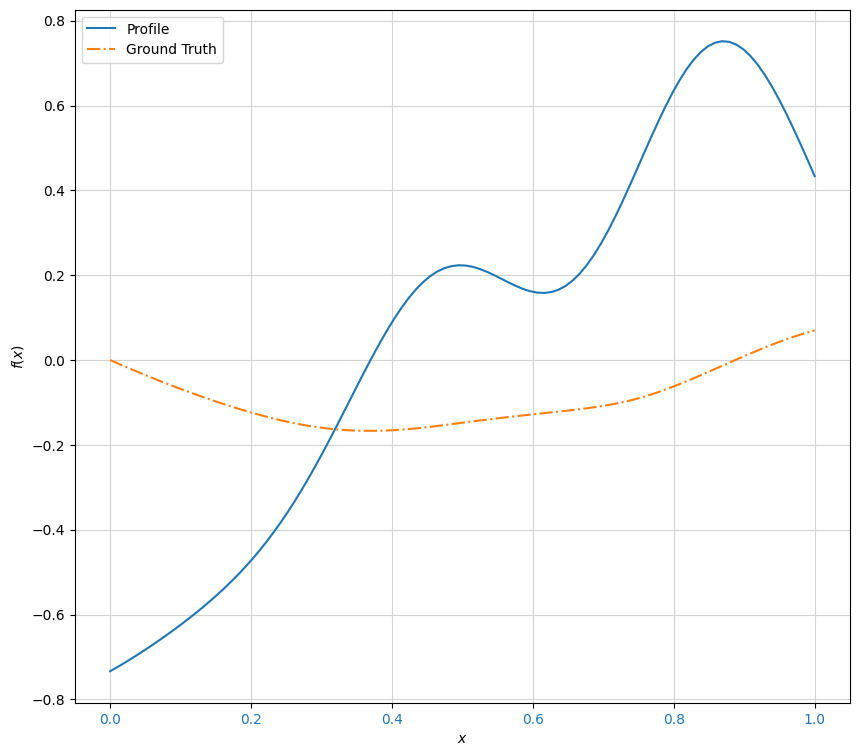

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [21]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepONET.predict([testBranchInput, testTrunkInput])
print(preds.shape)

(100, 100)
(100, 1)
4/4 [==============================] - 0s 2ms/step
(100, 1)


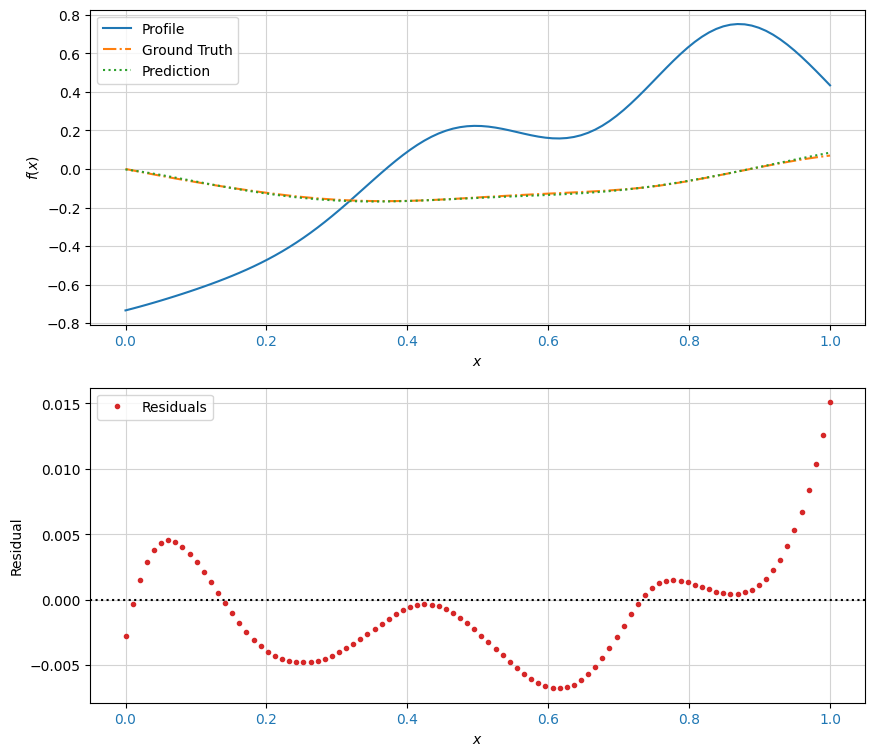

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [23]:
branchOutput = deepONET.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepONET.trunkNN(testTrunkInput)
print(trunkOutput.shape)

(100, 20)
(100, 20)


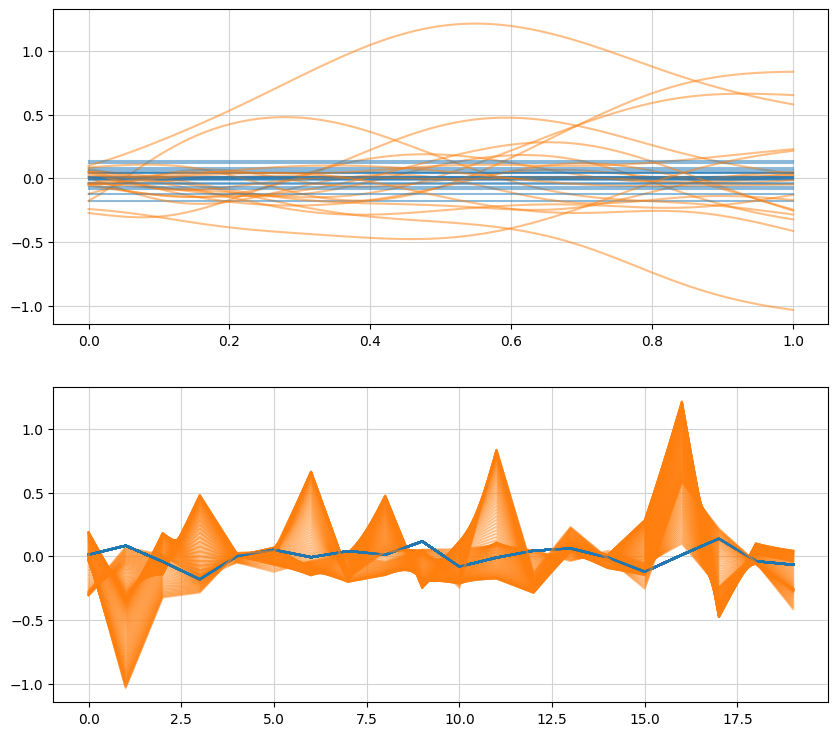

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [25]:
testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.05, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

Generating Solutions: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 63.84it/s]

(100,)
(1, 100)
(100, 1)


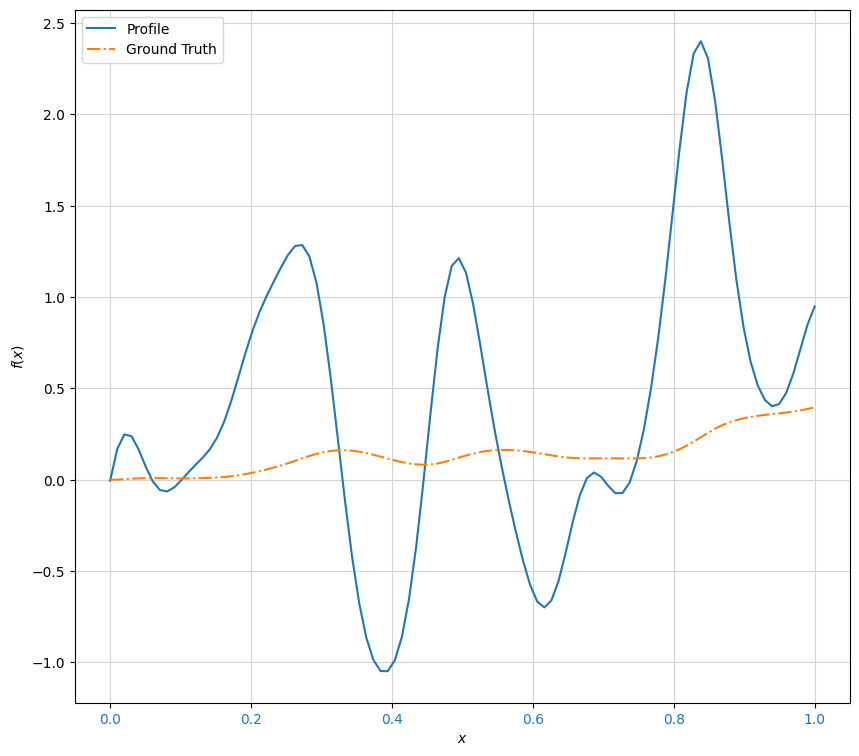

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [27]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepONET.predict([testBranchInput, testTrunkInput])
print(preds.shape)

(100, 100)
(100, 1)
4/4 [==============================] - 0s 3ms/step
(100, 1)


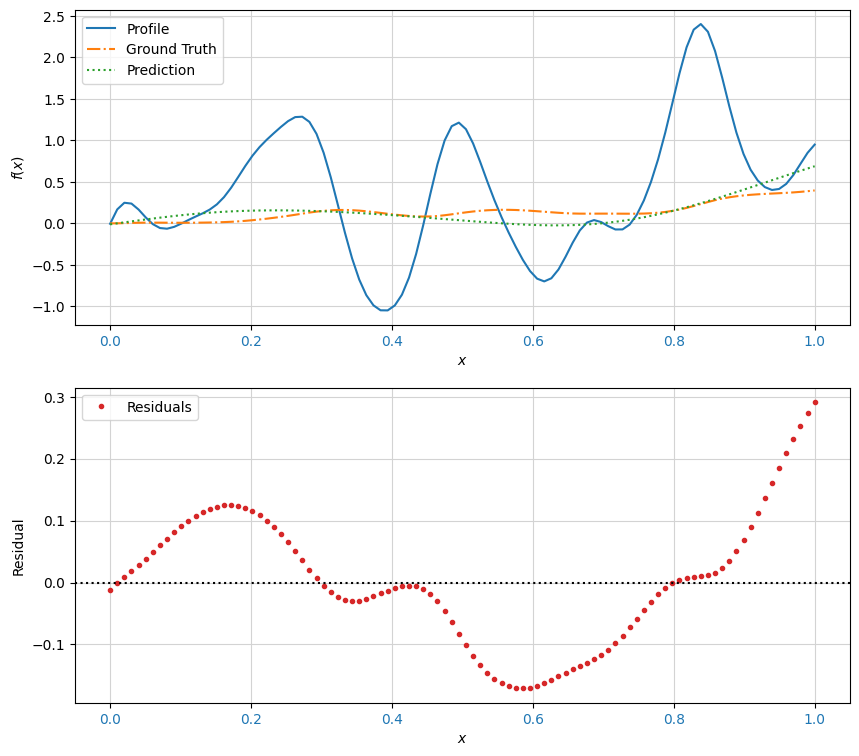

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [29]:
branchOutput = deepONET.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepONET.trunkNN(testTrunkInput)
print(trunkOutput.shape)

(100, 20)
(100, 20)


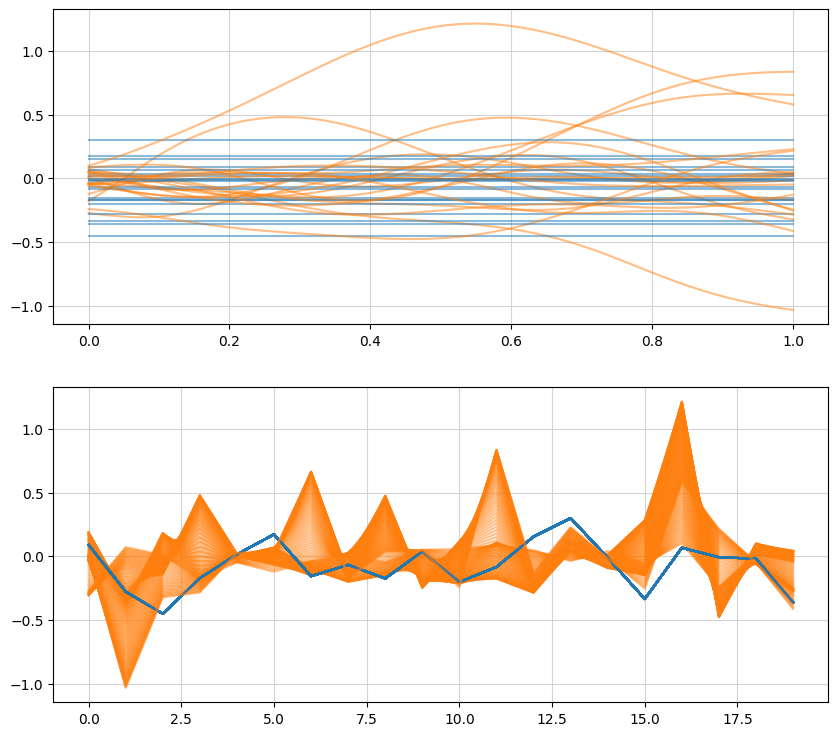

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [31]:
log_dir = os.path.join(".", "assets", "logs", "fits", f"DeepOPINN_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch=True, )

fileWriter = tf.summary.create_file_writer(os.path.join(log_dir, "metrics"))
fileWriter.set_as_default()

2023-12-22 03:03:56.141487: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-22 03:03:56.141513: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-12-22 03:03:56.141587: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [32]:
modelPath = os.path.join(".", "assets", "ml", "DeepOPINN", "deepOPINN.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', save_best_only=True, save_weights_only=True)

In [33]:
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.9, patience=50, min_lr=1e-9)
_callbacks = [tensorboard_callback, model_checkpoint_callback, learning_rate_callback]
callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=False)

In [34]:
branchHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"branchNETDense_layer{i+1}") for i in range(5)]
trunkHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"trunkNETDense_layer{i+1}") for i in range(5)]

branchNET = BranchNN(hiddenLayers=branchHiddenLayers, input_shape=(100,))
trunkNET = TrunkNN(hiddenLayers=trunkHiddenLayers, input_shape=(1,))
deepOPINN = DeepOPINN(branchNN=branchNET, trunkNN=trunkNET)

In [35]:
domain = np.linspace(0, 1, 100)

In [36]:
n = 1000

U = createSamples(lengthScale=0.2, k=n, domain=domain)

print(U.shape)
branch_input = []
for u in U:
    for t in domain:
        branch_input.append(u)
branch_input = np.array(branch_input)
print(branch_input.shape)

trunk_input = np.array([domain for i in range(n)]).reshape(-1, 1)
print(trunk_input.shape)

y = solutions(u=U, t=domain.reshape(-1, 1)).reshape(-1, 1)
print(y.shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
deepOPINN.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.losses.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])

(1000, 100)
(100000, 100)
(100000, 1)


Generating Solutions: 100%|██████████████████████████| 1000/1000 [00:01<00:00, 842.82it/s]

(100000, 1)


In [37]:
def generate_dataset(N, length_scale, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.
    
    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)
    
    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """
    
    # Create random fields
    random_field = createSamples(length_scale, N, domain=np.linspace(0, 1, 100))
    
    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N), desc="Generating Data", ncols = 80):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), random_field[i, :]), 
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)
        
    return X, y

In [38]:
# Create training dataset
N_train = 1000
length_scale_train = 0.2
X_train, y_train = generate_dataset(N_train, length_scale_train, ODE_solve=True)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test, ODE_solve=True)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

Generating Data: 100%|███████████████████████| 100/100 [00:00<00:00, 780.77it/s]


In [39]:
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))


In [40]:
print(f"X_train_ini shape {X_train_ini.shape}")
print(f"X_train shape {X_train.shape}")

X_train_ini shape (1000, 102)
X_train shape (100000, 102)


In [41]:
t_train = X_train[:, :1]
g_train = X_train[:, 1:-1]
gt_train = X_train[:, -1:]
g0_train = X_train_ini[:, 1:-1]

X_train = [g_train, t_train, gt_train]

In [42]:
deepOPINN.build(input_shape=[(None, 100), (None, 1)])

In [43]:
deepOPINN.summary()

Model: "deep_opinn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 branch_nn_1 (BranchNN)      multiple                  4120      
                                                                 
 trunk_nn_1 (TrunkNN)        multiple                  2140      
                                                                 
 bias_layer_1 (BiasLayer)    multiple                  1         
                                                                 
Total params: 6261 (24.46 KB)
Trainable params: 6261 (24.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# deepOPINN.fit(x=[branch_input, trunk_input], y=y, epochs=15, verbose=True, batch_size=1, validation_split=0.3, callbacks=tensorboard_callback)
deepOPINN.fit(x=X_train, y=y_train, epochs=5000, verbose=False, batch_size=100, validation_split=0.25, callbacks=_callbacks)

2023-12-22 03:04:04.818945: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-22 03:04:04.818966: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


2023-12-22 03:04:11.002018: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-12-22 03:04:11.480892: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-12-22 03:04:11.485480: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: ./assets/logs/fits/DeepOPINN_20231222-030356/plugins/profile/2023_12_22_03_04_11/bmbp.modem.xplane.pb


In [45]:
deepOPINN.load_weights(filepath=modelPath)

testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.2, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

Generating Solutions: 100%|████████████████████████████████| 1/1 [00:00<00:00, 154.90it/s]

(100,)
(1, 100)
(100, 1)


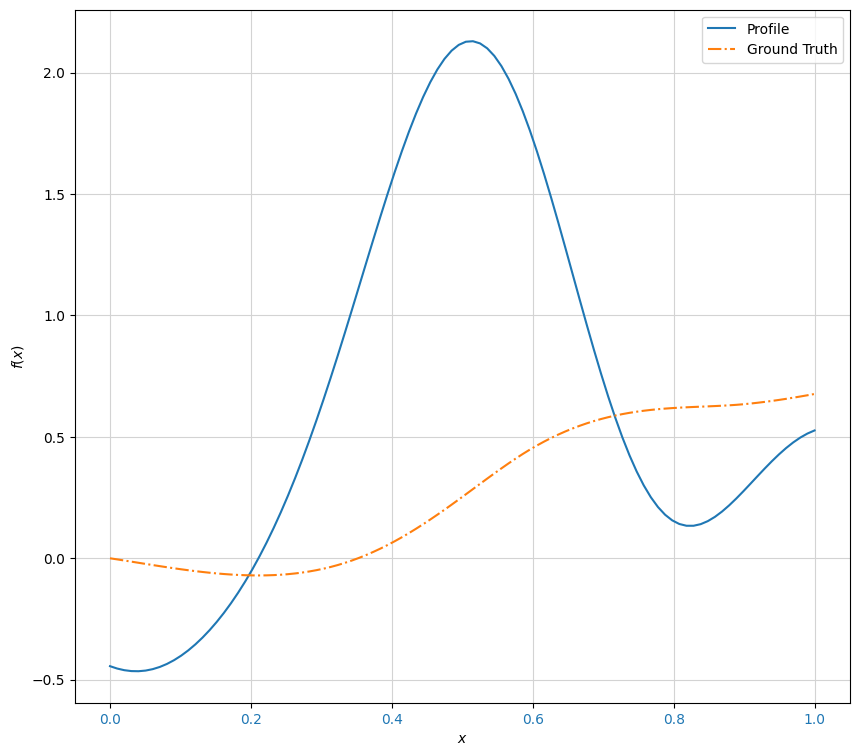

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [47]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepOPINN.predict([testBranchInput, testTrunkInput])
print(preds.shape)

(100, 100)
(100, 1)


4/4 [==============================] - 0s 11ms/step
(100, 1)


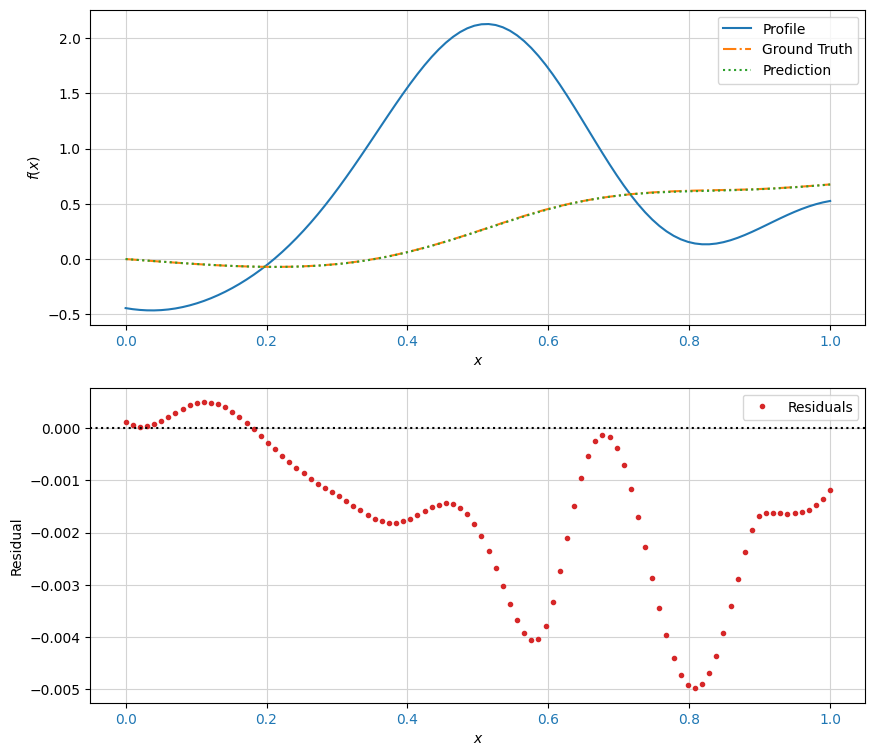

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [49]:
branchOutput = deepOPINN.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepOPINN.trunkNN(testTrunkInput)
print(trunkOutput.shape)

(100, 20)
(100, 20)


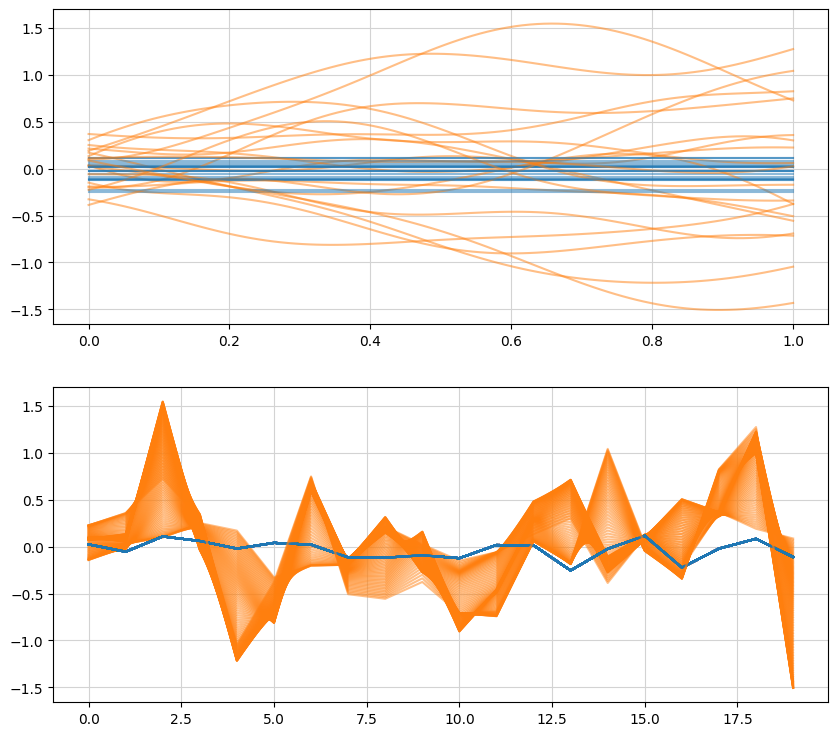

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [51]:
testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.05, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

Generating Solutions: 100%|████████████████████████████████| 1/1 [00:00<00:00, 103.11it/s]

(100,)
(1, 100)
(100, 1)


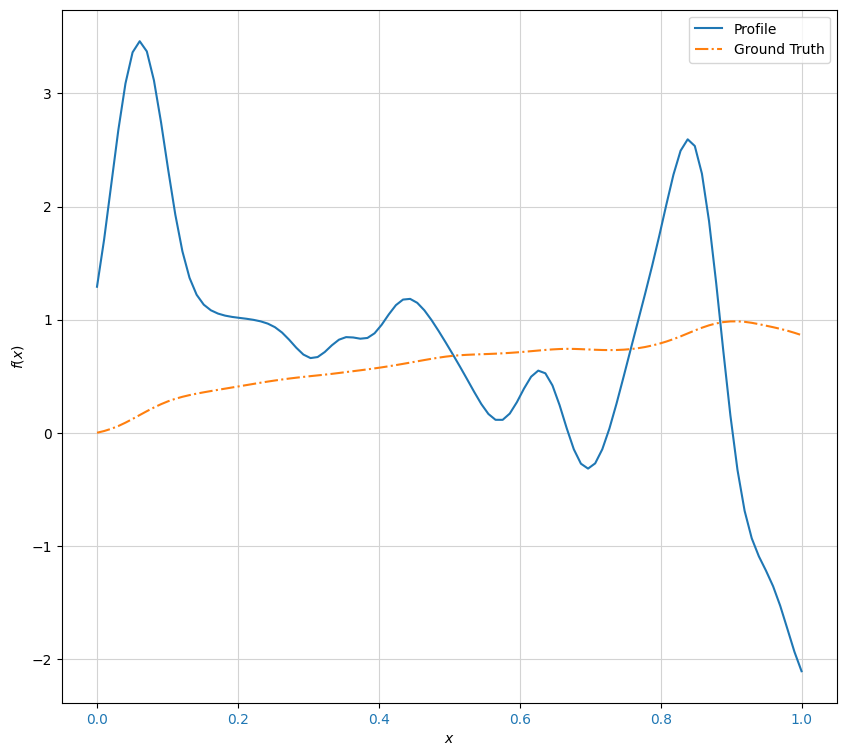

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [53]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepOPINN.predict([testBranchInput, testTrunkInput])
print(preds.shape)

(100, 100)
(100, 1)
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step
(100, 1)


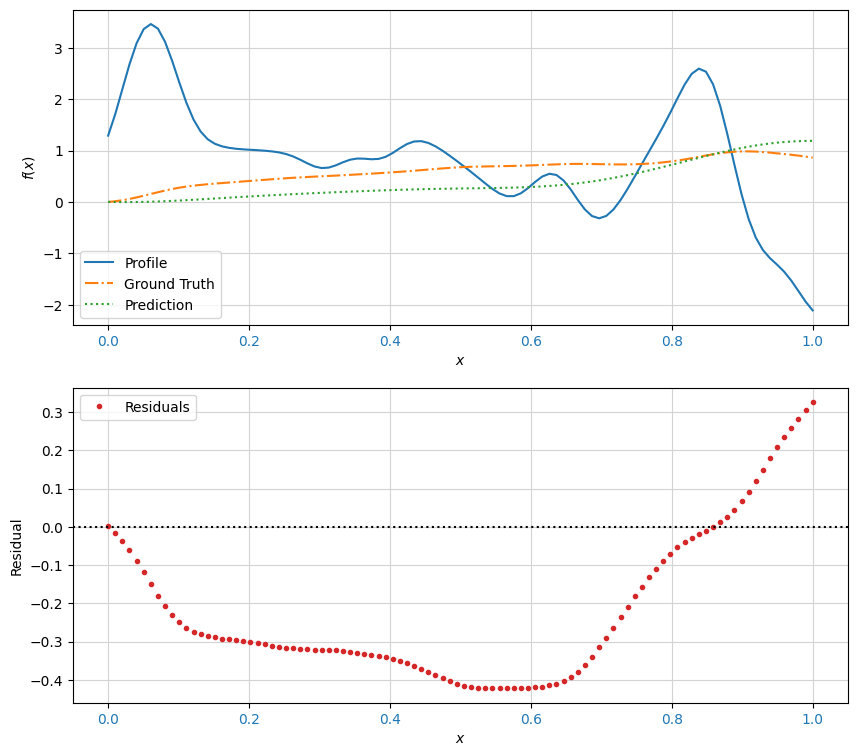

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [55]:
branchOutput = deepOPINN.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepOPINN.trunkNN(testTrunkInput)
print(trunkOutput.shape)

(100, 20)
(100, 20)


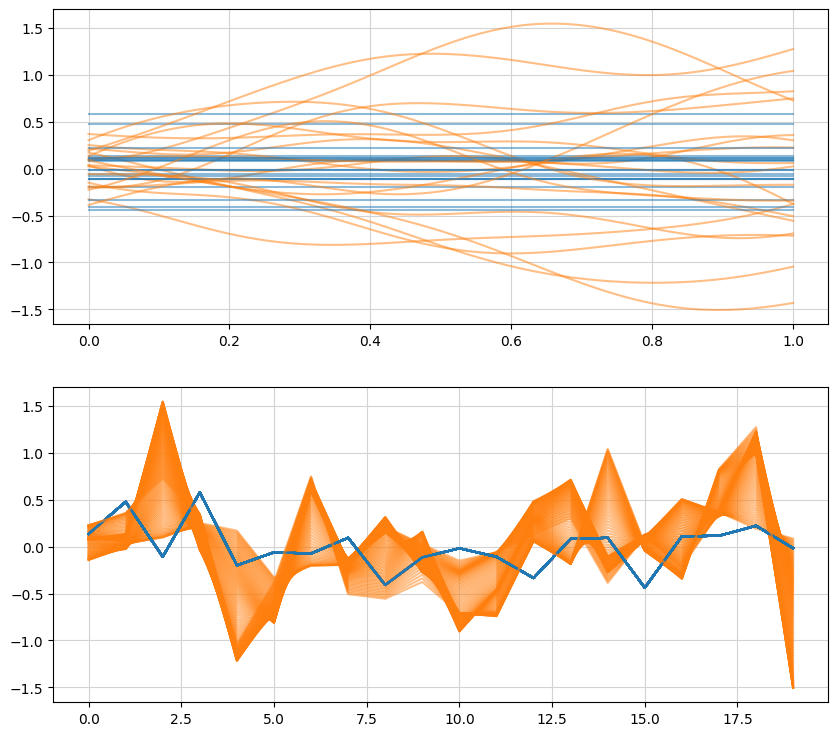

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [8]:
%tensorboard --logdir ./assets/logs --port=8080

In [ ]:
deepOPINN.modelFits

In [ ]:
deepOPINN.modelFits['Physics_Loss']

In [ ]:
scale = 0.6
N = 20
X_sample = np.linspace(0,1, 100)
y_sample = createSamples(lengthScale=scale, domain=X_sample, k=N)
u_sample = solutions(u=y_sample, t=X_sample)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, y_sample[index[i]], label = "Profile")
    ax.plot(X_sample, u_sample[index[i]], "-.", label = "Solution")
    ax.legend()
    ax.grid(True, color = 'lightgrey')

In [ ]:
# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

In [ ]:
print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N_train), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, X_train[index[i]*100, 1:-1], label = f"Profile at index {index[i]}")
    ax.plot(X_sample, y_train[index[i]*100:(index[i]+1)*100], "-.", label = f"Solution at index {index[i]}")
    ax.set_xlabel('t', fontsize=12)
    ax.set_ylabel('u(t)', fontsize=12)
    ax.legend()
    ax.grid(True, color = 'lightgrey')

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N_test), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, X_test[index[i]*100, 1:-1], label = f"Profile at index {index[i]}")
    ax.plot(X_sample, y_test[index[i]*100:(index[i]+1)*100], "-.", label = f"Solution at index {index[i]}")
    ax.set_xlabel('t', fontsize=12)
    ax.set_ylabel('u(t)', fontsize=12)
    ax.legend()
    ax.grid(True, color = 'lightgrey')

plt.show()

In [ ]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

In [ ]:
# Scaling 
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

In [ ]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

In [ ]:
def create_model(mean, var, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.
    
    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the DeepONet model
    """
    
    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['forcing'])), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)
    
    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)   
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)
    
    # Compute the dot product between branch and trunk net
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)
    
    # Add the bias
    output = BiasLayer()(dot_product)
    
    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)
    
    if verbose:
        model.summary()
        
    return model  

In [ ]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.
    
    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model
    
    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    
    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"forcing": u, "time": t})
    
    # Calculate gradients
    ds_dt = tape.gradient(s, t)
    
    # ODE residual
    ODE_residual = ds_dt - u_t
    
    return ODE_residual

In [ ]:
@tf.function
def train_step(X, X_init, IC_weight, ODE_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    
    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Calculate loss
        IC_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        
        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, total_loss, gradients

In [ ]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = tf.keras.metrics.Mean()
        self.mean_IC_loss = tf.keras.metrics.Mean()
        self.mean_ODE_loss = tf.keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")
        
    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())

In [ ]:
# Set up training configurations
n_epochs = 300
IC_weight= tf.constant(1.0, dtype=tf.float32)   
ODE_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []

# One test sample prediction
pred_profiles = []

# Set up optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):
    
    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('./assets/nn/NN_model.h5', monitor='val_loss', save_best_only=True)]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)
    
    # Start training process
    for epoch in range(1, n_epochs + 1):  
        print(f"Epoch {epoch}:")

        for X_init, X in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, total_loss, gradients = train_step(X, X_init, 
                                                                IC_weight, ODE_weight,
                                                                PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        ####### Validation
        val_res = ODE_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        X_val_ini = X_val[X_val[:, 0]==0]
        pred_ini_valid = PI_DeepONet.predict({"forcing": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
        val_IC = tf.reduce_mean(tf.keras.losses.mean_squared_error(0, pred_ini_valid))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")


        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")
        
        # Predict on one specific train samples
        sample_id = 25
        pred_profiles.append(PI_DeepONet.predict({"forcing": X_test[sample_id*100:(sample_id+1)*100, 1:-1], 
                                            "time": X_test[sample_id*100:(sample_id+1)*100, :1]}, batch_size=12800))
        
        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size) 

In [ ]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), val_loss_hist)
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Validation Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)
    
plt.savefig('loss.png', bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
# Create new model instance
PI_DeepONet = create_model(mean, var)

# Reload the saved model
PI_DeepONet.load_weights('assets/nn/NN_model.h5')

In [ ]:
print(mean)
print(var)

In [ ]:
print(f"Mean Forcing Shape: {mean['forcing'].shape}")
print(f"Mean time shape: {mean['time'].shape}")
print(f"Var Forcing Shape: {var['forcing'].shape}")
print(f"Var time shape: {var['time'].shape}")

In [ ]:
# Make prediction
pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False):.4e}")

In [ ]:
print(pred_test.shape)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
index = np.random.choice(np.arange(0, N_test), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, X_test[index[i]*100, 1:-1], label = f"Profile at index {index[i]}")
    ax.plot(X_sample, y_test[index[i]*100:(index[i]+1)*100], "-.", label = f"Solution at index {index[i]}")
    ax.plot(X_sample, pred_test[index[i]*100:(index[i]+1)*100], "-.", label = f"Prediction at index {index[i]}")
    ax.set_xlabel('t', fontsize=12)
    ax.set_ylabel('u(t)', fontsize=12)
    ax.legend()
    ax.grid(True, color = 'lightgrey')

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
index = np.random.choice(np.arange(0, N_test), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, y_test[index[i]*100:(index[i]+1)*100] - pred_test[index[i]*100:(index[i]+1)*100], "x", label = f"Residual at index {index[i]}")
    ax.axhline(0, linestyle = ':', color = 'k')
    ax.set_xlabel('t', fontsize=12)
    ax.set_ylabel('u(t)', fontsize=12)
    ax.legend()
    ax.grid(True, color = 'lightgrey')

plt.show()